In [2]:
#basics/util
import os
import glob
import pandas as pd
import numpy as np

#sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    CategoricalNB,
    ComplementNB,
    BernoulliNB,
)
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#plot
import seaborn as sns
import matplotlib.pyplot as plt

#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#NNet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
np.random.seed(42)

# Data extraction and Pre-processing

In [4]:
# Combine all PDBs into a single dataframe
drivepath = "drive/MyDrive/Structural Bio/project/features_df.csv"
#dfs = []
#list_dats = os.listdir(drivepath)

#for table in list_dats:
#  dfs.append(pd.read_csv(drivepath + table,sep='\t'))

df0 = pd.read_csv(drivepath) #pd.concat(dfs)

In [5]:
df = df0.copy()
df.dropna(inplace=True)

y = df["Interaction"].astype("category")

# Define training features
X = df[
    [
        "s_resn",
        "s_ss8",
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_resn",
        "t_ss8",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
        "Interaction"
    ]
]

Xcat = df[
    [
        "s_resn",
        "s_ss8",
        "s_rsa",
        "s_phi",
        "s_psi",
        "t_resn",
        "t_ss8",
        "t_rsa",
        "t_phi",
        "t_psi",
    ]
]

Xmini = df[
    [
        "s_resn",
        "t_resn",
        "s_ss8",
        "t_ss8"
    ]
]

X.head()

,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,...,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
2,R,-,0.137,19.0,2.0,-2.857,2.171,1.538,-0.055,1.502,...,18.0,21.0,-1.629,1.721,0.931,-0.179,-3.005,-0.503,-1.853,HBOND
5,Q,E,0.217,17.0,6.0,-2.672,2.564,0.931,-0.179,-3.005,...,20.0,14.0,-2.009,2.471,-0.032,0.326,2.213,0.908,1.313,HBOND
6,Q,E,0.217,17.0,6.0,-2.672,2.564,0.931,-0.179,-3.005,...,20.0,14.0,-2.009,2.471,-0.032,0.326,2.213,0.908,1.313,VDW
7,F,E,0.208,11.0,21.0,-2.756,2.364,-1.006,-0.590,1.891,...,8.0,12.0,-1.204,2.372,-1.239,-0.547,2.131,0.393,0.816,VDW
12,K,E,0.707,0.0,21.0,-2.126,2.218,1.831,-0.561,0.533,...,7.0,21.0,-2.488,1.669,1.050,0.302,-3.656,-0.259,-3.242,IONIC


In [6]:
bondtypes = X["Interaction"].unique()

#X[X["Interaction"] == 'IONIC']

In [7]:
Xcat.head()

,s_resn,s_ss8,s_rsa,s_phi,s_psi,t_resn,t_ss8,t_rsa,t_phi,t_psi
2,R,-,0.137,-2.857,2.171,Q,E,0.025,-1.629,1.721
5,Q,E,0.217,-2.672,2.564,T,E,0.014,-2.009,2.471
6,Q,E,0.217,-2.672,2.564,T,E,0.014,-2.009,2.471
7,F,E,0.208,-2.756,2.364,I,-,0.675,-1.204,2.372
12,K,E,0.707,-2.126,2.218,D,E,0.423,-2.488,1.669


In [8]:
# let's say "-" is undefined ("u")
ss8_dic = {
    'H': 0, # alpha-helix
    'B': 1, # isolated beta-bridge
    'E': 2, # extended strand
    'G': 3, # 3-10 helix
    'I': 4, # pi-helix
    'T': 5, # turn
    'S': 6, # bend
    'C':7, # coil
    '-':8 # undefined
}

In [9]:
bonds_custom = {
    'HBOND': 0,
    'IONIC': 1,
    'PICATION': 2,
    'PIHBOND': 3,
    'PIPISTACK': 4,
    'SSBOND': 5,
    'VDW': 6
}
numbonds = 7
ys = X["Interaction"].map(bonds_custom)
ys.head(10)

2     0
5     0
6     6
7     6
12    1
13    0
14    6
19    0
20    6
22    0
Name: Interaction, dtype: int64

In [10]:
residuenames = sorted(df["s_resn"].unique())
residuenames_dic = {
    'A':0, # alanine Aliphatic
 'C':1, #cysteine Sulfur
 'D':2, #aspartic acid Acidic
 'E':3, #glutamic acid Acidic
 'F':4, #phenylalanine Aromatic
 'G':5, #glycine Aliphatic
 'H':6, #histidine Basic Charged
 'I':7, #isoleucine Aliphatic
 'K':8, #lysine Basic Charged
 'L':9, #leucine Aliphatic
 'M':10, #methionine Aliphatic Sulfur
 'N':11, #asparagine Acidic
 'P':12, #proline Cyclic
 'Q':13, #glutamine Acidic
 'R':14, #arginine Basic Charged
 'S':15, #serine Hydroxyl
 'T':16, #threonine Hydroxyl
 'V':17, #valine Aliphatic
 'W':18, #tryptophan Aromatic
 'Y':19 #tyrosine Hydroxyl Aromatic
    }


#X["s_resn"] = X["s_resn"].map(residuenames_dic)
#X["t_resn"] = X["t_resn"].map(residuenames_dic)

#Xmini["s_resn"] = Xmini["s_resn"].map(residuenames_dic)
#Xmini["t_resn"] = Xmini["t_resn"].map(residuenames_dic)
Xmini.head()

,s_resn,t_resn,s_ss8,t_ss8
2,R,Q,-,E
5,Q,T,E,E
6,Q,T,E,E
7,F,I,E,-
12,K,D,E,E


In [11]:
#Xmini["s_resn"] = to_categorical(Xmini["s_resn"], num_classes= 20)

In [12]:
#scaler = StandardScaler()
#Xs = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#Xs

In [13]:
# create training set
Xm_train, Xm_temp, y_train, y_temp = train_test_split(Xmini, ys, test_size=0.3)
Xm_val, Xm_test, y_val, y_test = train_test_split(Xm_temp, y_temp, test_size=0.5)

Xc_train, Xc_temp, y_train, y_temp = train_test_split(Xcat, ys, test_size=0.3)
Xc_val, Xc_test, y_val, y_test = train_test_split(Xc_temp, y_temp, test_size=0.5)

X_train, X_test, y_train, y_test = train_test_split(X, ys, test_size=0.1)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

y_train = to_categorical(y_train, num_classes = numbonds)
y_val = to_categorical(y_val, num_classes = numbonds)
y_test = to_categorical(y_test, num_classes = numbonds)
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# encoding

In [14]:
def OHdata(df, numcols=None):
  encoder1 = OneHotEncoder(categories=[list("ACDEFGHIKLMNPQRSTVWY"), list("ACDEFGHIKLMNPQRSTVWY")],sparse_output=False)
  encoder2 = OneHotEncoder(categories=[list("HBEGITSC-"), list("HBEGITSC-")],sparse_output=False)

  features1 = encoder1.fit_transform(df[["s_resn", "t_resn"]])
  features2 = encoder2.fit_transform(df[["s_ss8", "t_ss8"]])

  if numcols:
    encoded_features = np.hstack([df[numcols],features1, features2])
  else: encoded_features = np.hstack([features1, features2])

  return encoded_features

In [15]:
numerical_cols = ["s_rsa","s_phi","s_psi","t_rsa","t_phi","t_psi"]
numerical_cols_long =  ["s_rsa","s_up","s_down","s_phi","s_psi","s_a1","s_a2","s_a3","s_a4","s_a5",
                 "t_rsa","t_up","t_down","t_phi","t_psi","t_a1","t_a2","t_a3","t_a4", "t_a5"]

In [16]:
dftrain = OHdata(X_train,numerical_cols_long)
#dfval = OHdata(X_val,numerical_cols_long)
dftest = OHdata(X_test,numerical_cols_long)


input_neurons = dftrain.shape[1]
print(f"{input_neurons} input_neurons")

78 input_neurons


# Neural Network

In [17]:
model = Sequential()
model.add(InputLayer(input_shape=(input_neurons,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numbonds, activation='softmax'))  # numbonds output neurons for n interaction types
optimus = Adam() #SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimus, metrics=['accuracy'])

In [21]:
dothis = False

kf = KFold(n_splits=6, shuffle=True, random_state=42)
fold_no = 1
history = []
if dothis: #caution: long runtime
  for train_index, val_index in kf.split(dftrain):
      X_tra, X_v = dftrain[train_index], dftrain[val_index]
      y_tra, y_v = y_train[train_index], y_train[val_index]

      print(f'Training fold {fold_no}...')
      his = model.fit(X_tra, y_tra, epochs=50, batch_size=256, verbose=1, validation_data=(X_v, y_v))
      history.append(his)
      fold_no += 1

In [29]:
#history = model.fit(dftrain, y_train, epochs=16, batch_size=256, validation_data=(dfval, y_val))

In [52]:
tr_err = []
val_err = []
for his in history:
  tr_err.append(his.history['accuracy'])
  val_err.append(his.history['val_accuracy'])
tr_err = np.reshape(tr_err,(-1,))
val_err = np.reshape(val_err,(-1,))

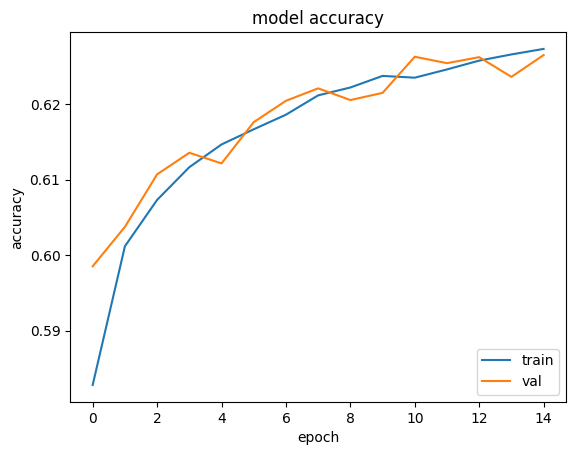

In [53]:
plt.plot(tr_err)
plt.plot(val_err)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [24]:
#confusion matrix
y_pred_probs = model.predict(dftest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

4599/4599 [==============================] - 12s 3ms/step
Confusion Matrix:
 [[81097     4     0     0     0    26  1243]
 [ 2790     0     0     0     0     1    17]
 [  655     0     0     0     0     0     3]
 [  164     0     0     0     0     0     4]
 [ 2926     0     0     0     0     0    24]
 [  144     0     0     0     0     0     6]
 [56992     3     0     1     0    18  1020]]


<Axes: >

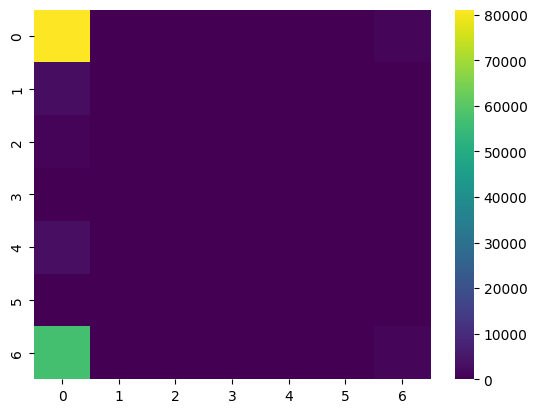

In [25]:
sns.heatmap(cm,cmap='viridis')

In [26]:
dfmini = pd.concat([Xmini,y],axis=1)
sbonds = dfmini[dfmini["Interaction"] == 'SSBOND']

#pd.merge(Xmini, y, how='inner')

In [27]:
sbonds[sbonds['t_resn'] != 'C']

,s_resn,t_resn,s_ss8,t_ss8,Interaction


# DATA AUGMENTATION

## introduction

In [28]:
abundancy_bonds = X.groupby(["Interaction"]).size()
abundancy_bonds

Interaction
HBOND        820333
IONIC         27538
PICATION       6874
PIHBOND        1669
PIPISTACK     30117
SSBOND         1657
VDW          583192
dtype: int64

In [29]:
rare_abundancy = abundancy_bonds[abundancy_bonds < 100000]
rare_abundancy

Interaction
IONIC        27538
PICATION      6874
PIHBOND       1669
PIPISTACK    30117
SSBOND        1657
dtype: int64

In [30]:
rarebonds = rare_abundancy.keys()
rarebonds

Index(['IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND'], dtype='object', name='Interaction')

Ok so classes 1,2,3,4,5 are severely underrepresented in the dataset and the network won't fit very well (I mean, it didn't). So to balance things out, we will oversample them via a custom data augmentation procedure. In order to maintain the abundancy hierarchy, we will oversample more the (relatively) more frequent among the rare classes, i.e.

|class|"oversamples" count|
|-----|:------------|
|IONIC(1)|20'000|
|PICATION(2)|15'000|
|PIHBOND(3)|10'000|
|PIPISTACK(4)|20'000|
|SSBOND(5)|10'000|

We are thus going to be adding a total of 75k records to our dataset, which we remind comprises ~1.5M records. The updated abundancy table for the rare classes should then be:

|class|updated count|
|-----|:------------|
|IONIC(1)|47'538|
|PICATION(2)|21'874|
|PIHBOND(3)|11'669|
|PIPISTACK(4)|50'117|
|SSBOND(5)|11'657|

In [72]:
Xx = X.copy()
Xx["s_resn"] = Xx["s_resn"].map(residuenames_dic)
Xx["t_resn"] = Xx["t_resn"].map(residuenames_dic)
Xx["s_ss8"] = Xx["s_ss8"].map(ss8_dic)
Xx["t_ss8"] = Xx["t_ss8"].map(ss8_dic)
Xx["Interaction"] = Xx["Interaction"].map(bonds_custom)

In [81]:
oversamples = (pd.Series([20000, 15000, 10000, 20000, 10000])*4).tolist() #see table above
oversamples

[80000, 60000, 40000, 80000, 40000]

In [73]:
mutacol = ['s_rsa', 's_up', 's_down', 's_phi', 's_psi','t_rsa', 't_up', 't_down', 't_phi', 't_psi']
mutatidx = [index for index, value in enumerate(Xx.columns) if value in mutacol]
mutatidx # this is the list of column indexes on which we want to perform DAUG

[2, 3, 4, 5, 6, 14, 15, 16, 17, 18]

In [74]:
# function to modify some entries of a row
def mod_row(row, factor=10, idxs = [], extract = -1, verbose=False):
  # idxs by default are all
  if len(idxs) < 1 : idxs = np.arange(0,row.shape[0]) # which indexes/columns can be modified?
  if extract < 0 : extract = np.random.choice(len(idxs)+1, 1) # how many indexes do you want to mod? NB choice(5,1) is btw 0 and 4 included so must do 5+1 to select a 5 (all items in row)
  col_mutanda = np.sort(np.random.choice(idxs,size=extract, replace=False)) # select randomly which columns to modify
  mrow = row.copy()
  mrow[col_mutanda] *= factor
  if verbose:
    print(f"extract = {extract}, col_mutanda = {col_mutanda}, row = {row}")

  return mrow

In [75]:
row = np.array([1,1,1,1,1])
mod_row(row, idxs = np.array([0,1,3]), verbose=True)
#np.random.choice(4,5)

extract = [3], col_mutanda = [0 1 3], row = [1 1 1 1 1]


array([10, 10,  1, 10,  1])

## testing

the idea is:
- do for every rare class:

  - create Xdumbo = X where interaction == class

  - create aug_df = []

  - do for every oversample in rare class:

      - take a row, mod it, append it to aug_df

  - append augmented class (aug_df) to the whole dataset

lil test on minuscule portion of the original dataframe.
remember
```
bonds_custom = {
    'HBOND': 0,
    'IONIC': 1,
    'PICATION': 2,
    'PIHBOND': 3,
    'PIPISTACK': 4,
    'SSBOND': 5,
    'VDW': 6
}```

In [83]:
for i in zip(rarebonds,rare_abundancy,oversamples):
  print(i)

('IONIC', 27538, 80000)
('PICATION', 6874, 60000)
('PIHBOND', 1669, 40000)
('PIPISTACK', 30117, 80000)
('SSBOND', 1657, 40000)


In [84]:
# DAUG
DAUG = pd.DataFrame([])
DAUG_factor = 1.01 # conservative tweak

for jj in range(5):
  print(oversamples[jj],rarebonds[jj],rare_abundancy[jj])
  Xdumbo = Xx[Xx["Interaction"] == jj+1]
  aug_rows = np.zeros(shape=(oversamples[jj],Xdumbo.shape[1])) # append is slow
  print(Xdumbo.shape)

  for ii in range(oversamples[jj]):
    pp = ii % rare_abundancy[jj] # this way, if 1669 < 10000, we restart
    roww = np.array(Xdumbo.iloc[pp]) #take a row
    aug_rows[ii] = mod_row(roww,factor = DAUG_factor, idxs=mutatidx, verbose=False) #mod it

  aug_df = pd.DataFrame(aug_rows, columns = Xx.columns)
  DAUG = pd.concat([DAUG,aug_df],ignore_index=True)

80000 IONIC 27538
(27538, 25)
60000 PICATION 6874
(6874, 25)
40000 PIHBOND 1669
(1669, 25)
80000 PIPISTACK 30117
(30117, 25)
40000 SSBOND 1657
(1657, 25)


In [85]:
DAUG.head()

,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,...,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,8.0,2.0,0.71407,0.00,21.21,-2.14726,2.24018,1.831,-0.561,0.533,...,7.00,21.21,-2.51288,1.68569,1.050,0.302,-3.656,-0.259,-3.242,1.0
1,14.0,6.0,0.04444,17.17,11.00,-1.42700,-0.42824,1.538,-0.055,1.502,...,6.06,12.12,-1.79000,1.61398,1.050,0.302,-3.656,-0.259,-3.242,1.0
2,8.0,0.0,0.54641,4.04,17.17,-1.09787,-0.64034,1.831,-0.561,0.533,...,7.07,14.14,-0.92011,-0.59994,1.357,-1.453,1.477,0.113,-0.837,1.0
3,2.0,0.0,0.00000,14.00,21.21,-1.08400,-0.86200,1.050,0.302,-3.656,...,14.14,4.04,-0.93800,2.40200,1.538,-0.055,1.502,0.440,2.897,1.0
4,3.0,0.0,0.44238,7.07,14.14,-1.17867,-0.73932,1.357,-1.453,1.477,...,14.14,9.09,-1.08777,-0.73427,1.831,-0.561,0.533,-0.277,1.648,1.0


In [86]:
Xx[Xx["Interaction"] == 1].head()

,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,...,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
12,8,2,0.707,0.0,21.0,-2.126,2.218,1.831,-0.561,0.533,...,7.0,21.0,-2.488,1.669,1.050,0.302,-3.656,-0.259,-3.242,1
168,14,6,0.044,17.0,11.0,-1.427,-0.424,1.538,-0.055,1.502,...,6.0,12.0,-1.790,1.598,1.050,0.302,-3.656,-0.259,-3.242,1
212,8,0,0.541,4.0,17.0,-1.087,-0.634,1.831,-0.561,0.533,...,7.0,14.0,-0.911,-0.594,1.357,-1.453,1.477,0.113,-0.837,1
334,2,0,0.000,14.0,21.0,-1.084,-0.862,1.050,0.302,-3.656,...,14.0,4.0,-0.938,2.402,1.538,-0.055,1.502,0.440,2.897,1
397,3,0,0.438,7.0,14.0,-1.167,-0.732,1.357,-1.453,1.477,...,14.0,9.0,-1.077,-0.727,1.831,-0.561,0.533,-0.277,1.648,1


As we can see above, the DAUG takes rows from the original dataframe and tweaks them. Only some specifics columns are untouched. (it would not make any sense, for example, to change the Atchley features or the amino acid species). Below is a more compact view of the modified dataframe, with just the columns of interest on display.

In [87]:
DAUG[mutacol].head()

,s_rsa,s_up,s_down,s_phi,s_psi,t_rsa,t_up,t_down,t_phi,t_psi
0,0.71407,0.00,21.21,-2.14726,2.24018,0.42723,7.00,21.21,-2.51288,1.68569
1,0.04444,17.17,11.00,-1.42700,-0.42824,0.41700,6.06,12.12,-1.79000,1.61398
2,0.54641,4.04,17.17,-1.09787,-0.64034,0.39592,7.07,14.14,-0.92011,-0.59994
3,0.00000,14.00,21.21,-1.08400,-0.86200,0.18100,14.14,4.04,-0.93800,2.40200
4,0.44238,7.07,14.14,-1.17867,-0.73932,0.40905,14.14,9.09,-1.08777,-0.73427


In [88]:
#last ceck size
print(Xx.shape)
print(DAUG.shape)

(1471380, 25)
(300000, 25)


And finally, the merger with the mother dataframe.

In [89]:
Xx = pd.concat([Xx,DAUG],ignore_index=True)

In [90]:
yy = Xx["Interaction"]
yy.shape

(1771380,)

## DAUG Neural Network

now some boring copypaste because I am tired and don't want to squeeze my brain some more thinking how to automate this stuff

as always, we start with

### pre-processing and One-Hot Encoding

In [91]:
Xx_train, Xx_test, yy_train, yy_test = train_test_split(Xx, yy, test_size=0.1)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

yy_train = to_categorical(yy_train, num_classes = numbonds)
yy_test = to_categorical(yy_test, num_classes = numbonds)
yy_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [92]:
Xx_train.shape[0]/6

265707.0

In [93]:
def OHdata_num(df, numcols=None):
  encoder1 = OneHotEncoder(categories=[list(np.arange(0,20)), list(np.arange(0,20))],sparse_output=False)
  encoder2 = OneHotEncoder(categories=[list(np.arange(0,9)), list(np.arange(0,9))],sparse_output=False)

  features1 = encoder1.fit_transform(df[["s_resn", "t_resn"]])
  features2 = encoder2.fit_transform(df[["s_ss8", "t_ss8"]])

  if numcols:
    encoded_features = np.hstack([df[numcols],features1, features2])
  else: encoded_features = np.hstack([features1, features2])

  return encoded_features

In [94]:
#numerical_cols_long =  ["s_rsa","s_up","s_down","s_phi","s_psi","s_a1","s_a2","s_a3","s_a4","s_a5",
                 # "t_rsa","t_up","t_down","t_phi","t_psi","t_a1","t_a2","t_a3","t_a4", "t_a5"]
                 # copied from above

DAUGtrain = OHdata_num(Xx_train,numerical_cols_long)
DAUGtest = OHdata_num(Xx_test,numerical_cols_long)

input_neurons = DAUGtrain.shape[1]
print(f"{input_neurons} input_neurons")

78 input_neurons


In [114]:
modelD = Sequential()
modelD.add(InputLayer(input_shape=(input_neurons,)))
modelD.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
modelD.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
modelD.add(Dense(numbonds, activation='softmax'))  # numbonds output neurons for n interaction types
optimus = Adam() #SGD(learning_rate=0.01)
modelD.compile(loss='categorical_crossentropy', optimizer=optimus, metrics=['accuracy'])

In [ ]:
kf = KFold(n_splits=6, shuffle=True, random_state=42)
fold_no = 1
history = []
for train_index, val_index in kf.split(DAUGtrain):
    X_tra, X_v = DAUGtrain[train_index], DAUGtrain[val_index]
    y_tra, y_v = yy_train[train_index], yy_train[val_index]

    print(f'Training fold {fold_no}...')
    his = modelD.fit(X_tra, y_tra, epochs=5, batch_size=256, verbose=1, validation_data=(X_v, y_v))
    history.append(his)
    fold_no += 1

Training fold 1...
Epoch 1/5
5190/5190 [==============================] - 37s 7ms/step - loss: 0.7771 - accuracy: 0.6003 - val_loss: 0.7464 - val_accuracy: 0.6165
Epoch 2/5
5186/5190 [============================>.] - ETA: 0s - loss: 0.7364 - accuracy: 0.6204

In [103]:
tr_err = []
val_err = []
for his in history:
  tr_err.append(his.history['accuracy'])
  val_err.append(his.history['val_accuracy'])
tr_err = np.reshape(tr_err,(-1,))
val_err = np.reshape(val_err,(-1,))

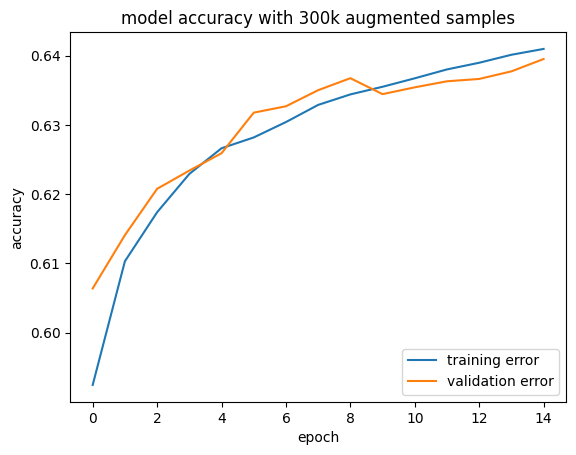

In [112]:
plt.plot(tr_err)
plt.plot(val_err)
plt.title(f'model accuracy with {int(sum(oversamples)/1000)}k augmented samples')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training error', 'validation error'], loc='lower right')
plt.show()

In [105]:
#confusion matrix
y_pred_probs = modelD.predict(DAUGtest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(yy_test, axis=1)
cmdaug = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cmdaug)

5536/5536 [==============================] - 11s 2ms/step
Confusion Matrix:
 [[67354  4907  1178   248  1169    47  7039]
 [ 1662  9035     0     0     0     0    25]
 [  263     0  6145   252     0     0    69]
 [  188     1   301  3448   118     0   103]
 [    2     0     0   174 10877     0     3]
 [    0     0     0     0     0  4186     0]
 [39764  2961  1323   382  1603   159 12152]]


<Axes: >

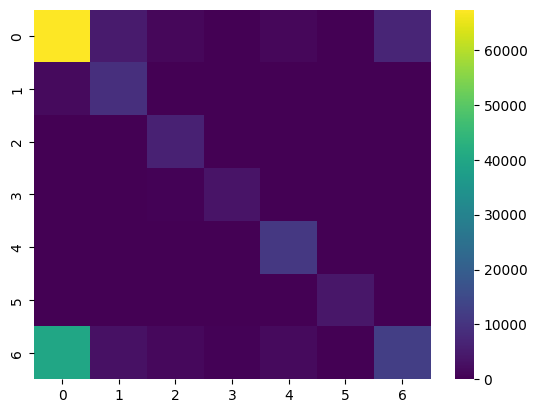

In [106]:
sns.heatmap(cmdaug, cmap='viridis')

test on non-augmented dataset?

In [107]:
#dftest y_test
y_pred_probs = modelD.predict(dftest)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

4599/4599 [==============================] - 10s 2ms/step
Confusion Matrix:
 [[67894  4995  1248   261  1127    58  6787]
 [  413  2384     0     0     0     0    11]
 [   33     0   599    25     0     0     1]
 [    2     0    15   144     4     0     3]
 [    0     0     0    36  2913     0     1]
 [    0     0     0     0     0   150     0]
 [39514  2975  1285   323  1657   132 12148]]


<Axes: >

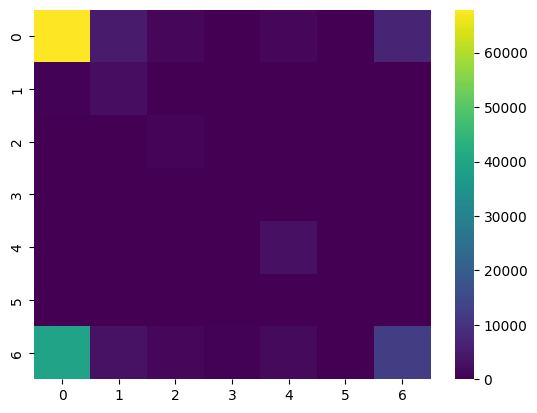

In [108]:
sns.heatmap(cm, cmap='viridis')